In [1]:
%matplotlib inline

Both simulations are the summary taken from these 2 articles:
* https://www.statisticshowto.com/probability-and-statistics/t-test/
* https://www.investopedia.com/terms/t/t-test.asp

Data for our simulation is taken from MysIDC (Malaysia Informative Data Centre). Kudos for Malaysia Government because now they have taken a small initiative in reducing data illiteracy among Malaysian citizen.

# T-test

T-test is a statistical tool that is used by analysts to help comparing things, specifically comparing the mean difference between two things of a same type. For instance, let's say a pet company is selling cat foods Brand A and Brand B. At the end of year, the company's stakeholders ask the CEO to present data for manufacturing cost of the company. A good CEO will not just telling the stakeholders if they have increase/decrease manufacturing cost, but also must enlighten the stakeholders on what is the cause of the increase/decrease of the manufacturing cost. Maybe the manufacturing cost is driven by the cat food Brand A, and not by Brand B. Or maybe it is the other way around? 

So in order to find out the answer to the question above, what the CEO can do is to use the T-test to find out if it is true that there is a significant different between Brand A manufacturing cost and Brand B manufacturing cost.

There are 3 things that T-test is useful for:
* Compare means between two groups (Independent Sample T-test)

If equal variance (use levene test/bartlett test/chi square test etc.):
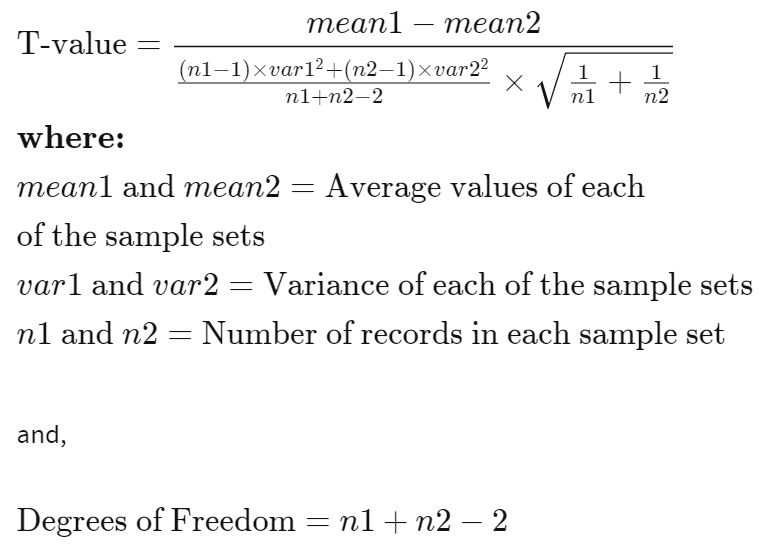

If unequal variance:
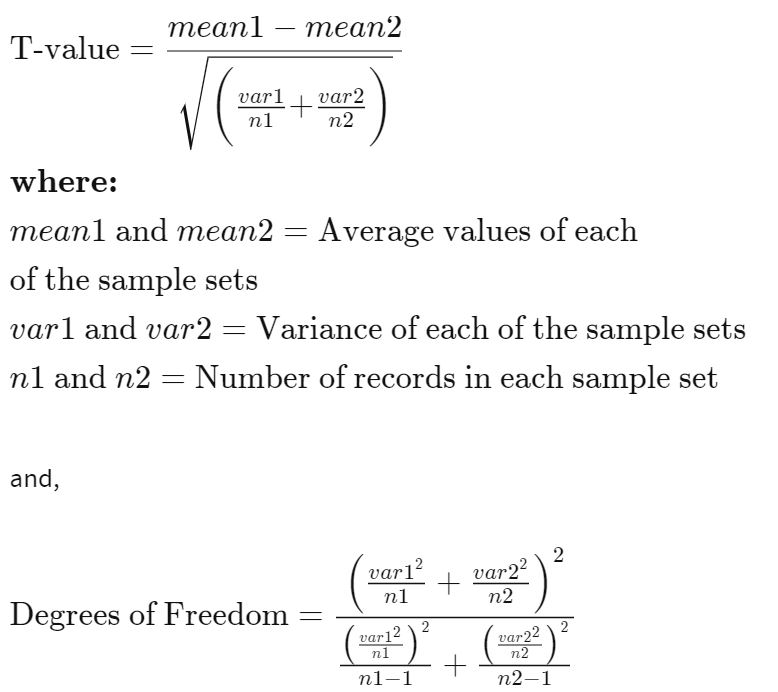

* Compare means of a group but with 2 different times (Paired Sample T-test)
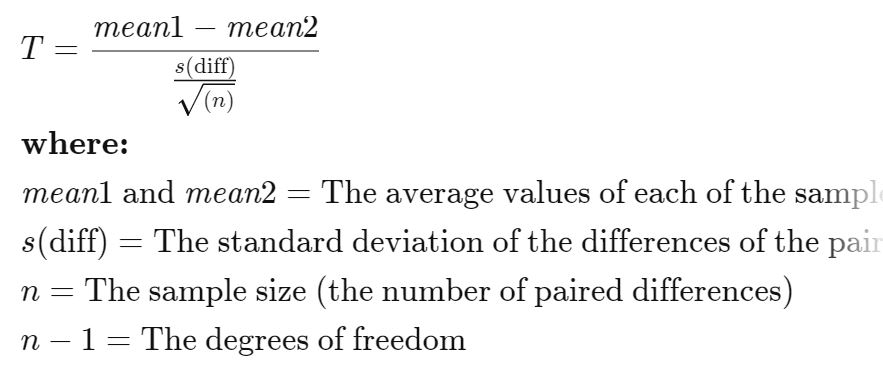

* Compare one mean from the population mean (One Sample T-test)

The t-statistic is given by
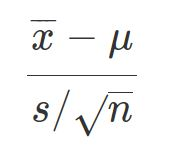

## Independent Sample T-test

For the simulation below, I will go through briefly how the T-test is used and will use the Crustacean & Molluscs data from MysIDC as an example.

In [1]:
import pandas as pd
import numpy as np

path = 'C:/Users/farea/Desktop/10.3.7 Production of Crustacean & Molluscs (Brackishwater Aquaculture) Malaysia 2000 - 2019_dataset.xlsx'

data = pd.read_excel(path)
data

,Category,Sub-Category,Year,Quantity ('000 Tonnes),Value (RM Million)
0,\nCrustacean & Molluscs,Cockle,2000,64.400,50.650
1,\nCrustacean & Molluscs,Cockle,2001,70.820,55.730
2,\nCrustacean & Molluscs,Cockle,2002,78.710,62.400
3,\nCrustacean & Molluscs,Cockle,2003,71.070,56.770
4,\nCrustacean & Molluscs,Cockle,2004,64.560,54.210
...,...,...,...,...,...
95,\nCrustacean & Molluscs,Shrimp,2015,58.000,1221.550
96,\nCrustacean & Molluscs,Shrimp,2016,43.253,918.632
97,\nCrustacean & Molluscs,Shrimp,2017,45.783,1067.337
98,\nCrustacean & Molluscs,Shrimp,2018,45.920,1114.950


In [2]:
data['Sub-Category'].unique()

array(['Cockle', 'Mussel', 'Oyster', 'Seaweed', 'Shrimp'], dtype=object)

Since T-test can only be used to compare two things, I will choose seaweed and shrimp because usually I will put these two into the dishes that I cook. I would like to know if there is a different in the quantity being produce in Malaysia so that when I go to the grocery, I will know which seafood should I buy (since usually if we have abundant source of food, the price would go low).

In [34]:
data = data[(data['Sub-Category']=='Shrimp') | (data['Sub-Category']=='Seaweed')]
data['Sub-Category'].unique()

array(['Seaweed', 'Shrimp'], dtype=object)

checking if the two sample have equal variance or not

In [8]:
from scipy.stats import levene, bartlett

df1 = data[(data['Sub-Category']=='Shrimp')]
df2 = data[(data['Sub-Category']=='Seaweed')]

test_stat1, p1 = levene(df1["Quantity ('000 Tonnes)"], df2["Quantity ('000 Tonnes)"])
test_stat2, p2 = bartlett(df1["Quantity ('000 Tonnes)"], df2["Quantity ('000 Tonnes)"])
print('Levene Test, p-value: ', p1,'| Bartlett Test, p-value: ', p2)

Levene Test, p-value:  1.5959518962965623e-08 | Bartlett Test, p-value:  1.500116951521517e-10


Since we have unequal variance (because our levene & bartlett p-value is so small), we'll need to use t-test with unequal variance. If we use pingouin package to run this T-test, we'll obtain

In [9]:
import pingouin as pg

# use correction for unequal variance
pg.ttest(df1["Quantity ('000 Tonnes)"],df2["Quantity ('000 Tonnes)"], confidence=0.95, correction=True) 

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.181734,20.095393,two-sided,0.000456,"[-147.61, -49.38]",1.322381,141.689,0.98274


In [14]:
print('Mean difference: ', np.mean(df1["Quantity ('000 Tonnes)"]) - np.mean(df2["Quantity ('000 Tonnes)"]),
     '\nVar Shrimp: ', np.var(df1["Quantity ('000 Tonnes)"]),
     '\nVar Seaweed: ', np.var(df2["Quantity ('000 Tonnes)"]),
     )

Mean difference:  -98.49650544640815 
Var Shrimp:  295.58183262305744 
Var Seaweed:  10245.431109389898


Which means that with a 95% confidence level, we do have a significant difference in the quantity produce between shrimp and seaweed.

Now, if we do this comparison the hard way, can we get the same output? For the following steps, I will:

* Sample 20 data point with replacement from shrimp data set. Another 20 data point from seaweed data set.
* Calculate the t-statistic for the sampled data.
* Run the above 2 steps for 10000 times.
* Plot our t-distribution and compare it with the actual t-distribution (with df as per 2nd image above).

In [11]:
test_stat = []

for i in range(10000):
    rep_shrimp = np.random.choice(df1["Quantity ('000 Tonnes)"], 20)
    rep_seaweed = np.random.choice(df2["Quantity ('000 Tonnes)"], 20)

    mean1 = np.mean(rep_shrimp)
    mean2 = np.mean(rep_seaweed)
    var1 = np.var(rep_shrimp)
    var2 = np.var(rep_seaweed)

    t = (mean1 - mean2)/np.sqrt((var1 + var2)/20)
    test_stat.append(t)

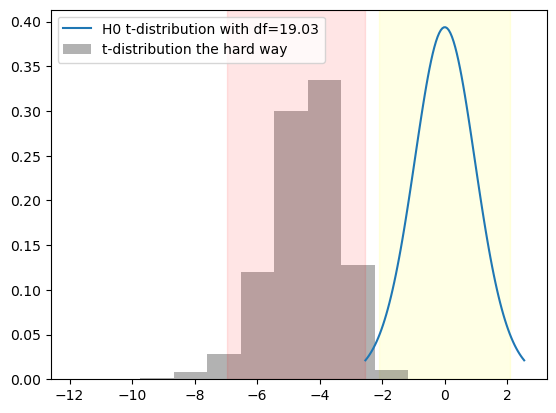

In [20]:
var_shrimp = np.var(df1["Quantity ('000 Tonnes)"])
var_seaweed = np.var(df2["Quantity ('000 Tonnes)"])
a = (var_shrimp**2)/20
b = (var_seaweed**2)/20
deg_freedom = ((a+b)**2)/((a**2 + b**2)/19) # df = 19.03

from scipy.stats import t
import matplotlib.pyplot as plt

x = np.linspace(t.ppf(0.01, deg_freedom),
                t.ppf(0.99, deg_freedom), 100)
rv = t(deg_freedom)

fig, ax = plt.subplots()
ax.plot(x, rv.pdf(x), label='H0 t-distribution with df=19.03')
ax.axvspan(t.ppf(0.025, deg_freedom), t.ppf(0.975, deg_freedom), alpha=0.1, color='yellow')
ax.hist(test_stat, density=True, alpha=0.3, label='t-distribution the hard way', color='black')
ax.axvspan(np.percentile(test_stat, 2.5), np.percentile(test_stat, 97.5), alpha=0.1, color='red')
plt.legend()

And there you go. 

Since 0 is not contained within our t-test 95% confidence interval ([-147.61, -49.38]), 

our p-value < 0.025,  

and because we don't have an overlap 95% confidence interval between the red and yellow region, 

we are pretty sure that there exist a significant different between the quantity production of shrimp and seaweed (which is the shrimp quantity production < seaweed quantity production).

Note: Some of you guys might confuse why I said that there is a significant difference for the mean between shrimp and seaweed because from the plot above, it seems like there are still data point which lies underneath our H0 distribution. My answer is that, this t-test is done with 95% confidence level. This means that we might still get 5% type 1 error rate (falsely reject the H0 when H0 is true). 

In [54]:
data

,Category,Sub-Category,Year,Quantity ('000 Tonnes),Value (RM Million)
60,\nCrustacean & Molluscs,Seaweed,2000,16.120000,6.930000
61,\nCrustacean & Molluscs,Seaweed,2001,18.860000,7.550000
62,\nCrustacean & Molluscs,Seaweed,2002,25.620000,11.530000
63,\nCrustacean & Molluscs,Seaweed,2003,27.610000,13.800000
64,\nCrustacean & Molluscs,Seaweed,2004,30.960000,15.480000
65,\nCrustacean & Molluscs,Seaweed,2005,31.430000,15.710000
66,\nCrustacean & Molluscs,Seaweed,2006,43.200000,6.910000
67,\nCrustacean & Molluscs,Seaweed,2007,90.270000,18.050000
68,\nCrustacean & Molluscs,Seaweed,2008,111.300000,22.260000
69,\nCrustacean & Molluscs,Seaweed,2009,139.000000,27.770000


Next, we will continue with the T-test for Paired Sample T-test with a new dataset.